In [1]:
!pip install wheel==0.37.1 setuptools==59.6.0
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.6/952.6 kB 34.7 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.40.0
    Uninstalling wheel-0.40.0:
      Successfully uninstalled wheel-0.40.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 59.6.0 which is incompatible.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 59.6.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/co

In [2]:
from math import ceil
from dataclasses import dataclass
from typing import List

import gym
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import \
    Conv2D, Lambda, Dropout, Flatten, \
    Dense, Input, Reshape, Conv2DTranspose

In [3]:
@dataclass
class DreamerSettings:
    action_dims: List[int]
    obs_dims: List[int]
    repr_dims: List[int]
    hidden_dims: List[int]
    enc_dims: List[int]
    dropout_rate: float = 0.2

    @property
    def repr_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1]

    @property
    def repr_out_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1] + self.hidden_dims[0]

In [4]:
def create_state_encoder_model(settings: DreamerSettings) -> Model:
    # observation t -> encoded state t
    model_in = Input(settings.obs_dims, name="enc_out")
    norm_img = Lambda(lambda x: x / 127.5 - 1.0)
    cnn_1 = Conv2D(16, (5, 5), strides=(2, 2), padding="same", activation="relu")
    cnn_2 = Conv2D(16, (3, 3), strides=(2, 2), padding="same", activation="relu")
    cnn_3 = Conv2D(16, (3, 3), strides=(2, 2), padding="same", activation="relu")
    cnn_4 = Conv2D(8, (3, 3), padding="same", activation="relu")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)
    drop_4 = Dropout(rate=settings.dropout_rate)
    flatten = Flatten()
    dense_out = Dense(settings.enc_dims[0], activation="linear", name="enc_dense")

    img_in = norm_img(model_in)
    prep_model_convs = drop_4(cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(img_in))))))))
    model_out = dense_out(flatten(prep_model_convs))
    return Model(inputs=model_in, outputs=model_out, name="encoder_model")


def create_state_decoder_model(settings: DreamerSettings) -> Model:
    # concat(representation t+1, hidden state t+1) -> (obs t+1)
    image_channels = settings.obs_dims[-1]
    upscale_source_dims = (settings.obs_dims[0] // 8 * settings.obs_dims[1] // 8) * 8

    model_in = Input(settings.enc_dims[0], name="repr_out")
    dense_in = Dense(upscale_source_dims, activation="linear", name="dec_in")
    reshape_in = Reshape((settings.obs_dims[0] // 8, settings.obs_dims[1] // 8, -1))
    cnn_1 = Conv2DTranspose(8, (3, 3), strides=(2, 2), padding="same", activation="relu")
    cnn_2 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu")
    cnn_3 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu")
    cnn_4 = Conv2D(16, (5, 5), padding="same", activation="relu")
    cnn_5 = Conv2D(image_channels, (1, 1), padding="same", activation="sigmoid")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)
    scale_255 = Lambda(lambda x: x * 255)

    prep_in = reshape_in(dense_in(model_in))
    model_out = scale_255(cnn_5(cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(prep_in)))))))))
    return Model(inputs=model_in, outputs=model_out, name="decoder_model")

In [5]:
def sample_obs(env: gym.Env, num_obs: int) -> tf.data.Dataset:
    all_obs = []
    done = False
    obs = env.reset()
    all_obs.append(obs)
    while len(all_obs) < num_obs:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        all_obs.append(obs)
        if done and len(all_obs) < num_obs:
            obs = env.reset()
            all_obs.append(obs)
    return tf.data.Dataset.from_tensor_slices(tensors=(np.array(all_obs)))

In [6]:
env = gym.make("ALE/Pong-v5")
settings = DreamerSettings([1], [64, 64, 3], [32, 32], [512], [128])

timesteps = 10_000
dataset = sample_obs(env, timesteps)
dataset = dataset.map(lambda obs: tf.image.resize(obs, settings.obs_dims[:2]))
dataset = dataset.map(lambda obs: (obs, obs))

In [7]:
encoder = create_state_encoder_model(settings)
decoder = create_state_decoder_model(settings)

model_in = Input(settings.obs_dims, name="enc_out")
model_out = decoder(encoder(model_in))
model = Model(inputs=model_in, outputs=model_out, name="autoencoder_model")

In [8]:
batch_size = 64
num_eval_batches = ceil((timesteps // batch_size) * 0.1)
dataset = dataset.batch(64)
train_dataset = dataset.skip(num_eval_batches)
eval_dataset = dataset.take(num_eval_batches)
train_dataset = train_dataset.shuffle(100)

model.compile(optimizer="adam", loss="mse")
model.fit(x=train_dataset, epochs=120, validation_data=eval_dataset)

Epoch 1/120
141/141 [==============================] - 24s 27ms/step - loss: 1979.9360 - val_loss: 797.0648
Epoch 2/120
141/141 [==============================] - 3s 18ms/step - loss: 348.7720 - val_loss: 195.1664
Epoch 3/120
141/141 [==============================] - 4s 18ms/step - loss: 101.4591 - val_loss: 175.2463
Epoch 4/120
141/141 [==============================] - 3s 17ms/step - loss: 81.8841 - val_loss: 160.9493
Epoch 5/120
141/141 [==============================] - 3s 17ms/step - loss: 74.7928 - val_loss: 131.8894
Epoch 6/120
141/141 [==============================] - 4s 19ms/step - loss: 67.0370 - val_loss: 84.8668
Epoch 7/120
141/141 [==============================] - 3s 17ms/step - loss: 61.7186 - val_loss: 79.3885
Epoch 8/120
141/141 [==============================] - 4s 27ms/step - loss: 58.4864 - val_loss: 77.3155
Epoch 9/120
141/141 [==============================] - 5s 27ms/step - loss: 56.6548 - val_loss: 68.0403
Epoch 10/120
141/141 [==============================] 

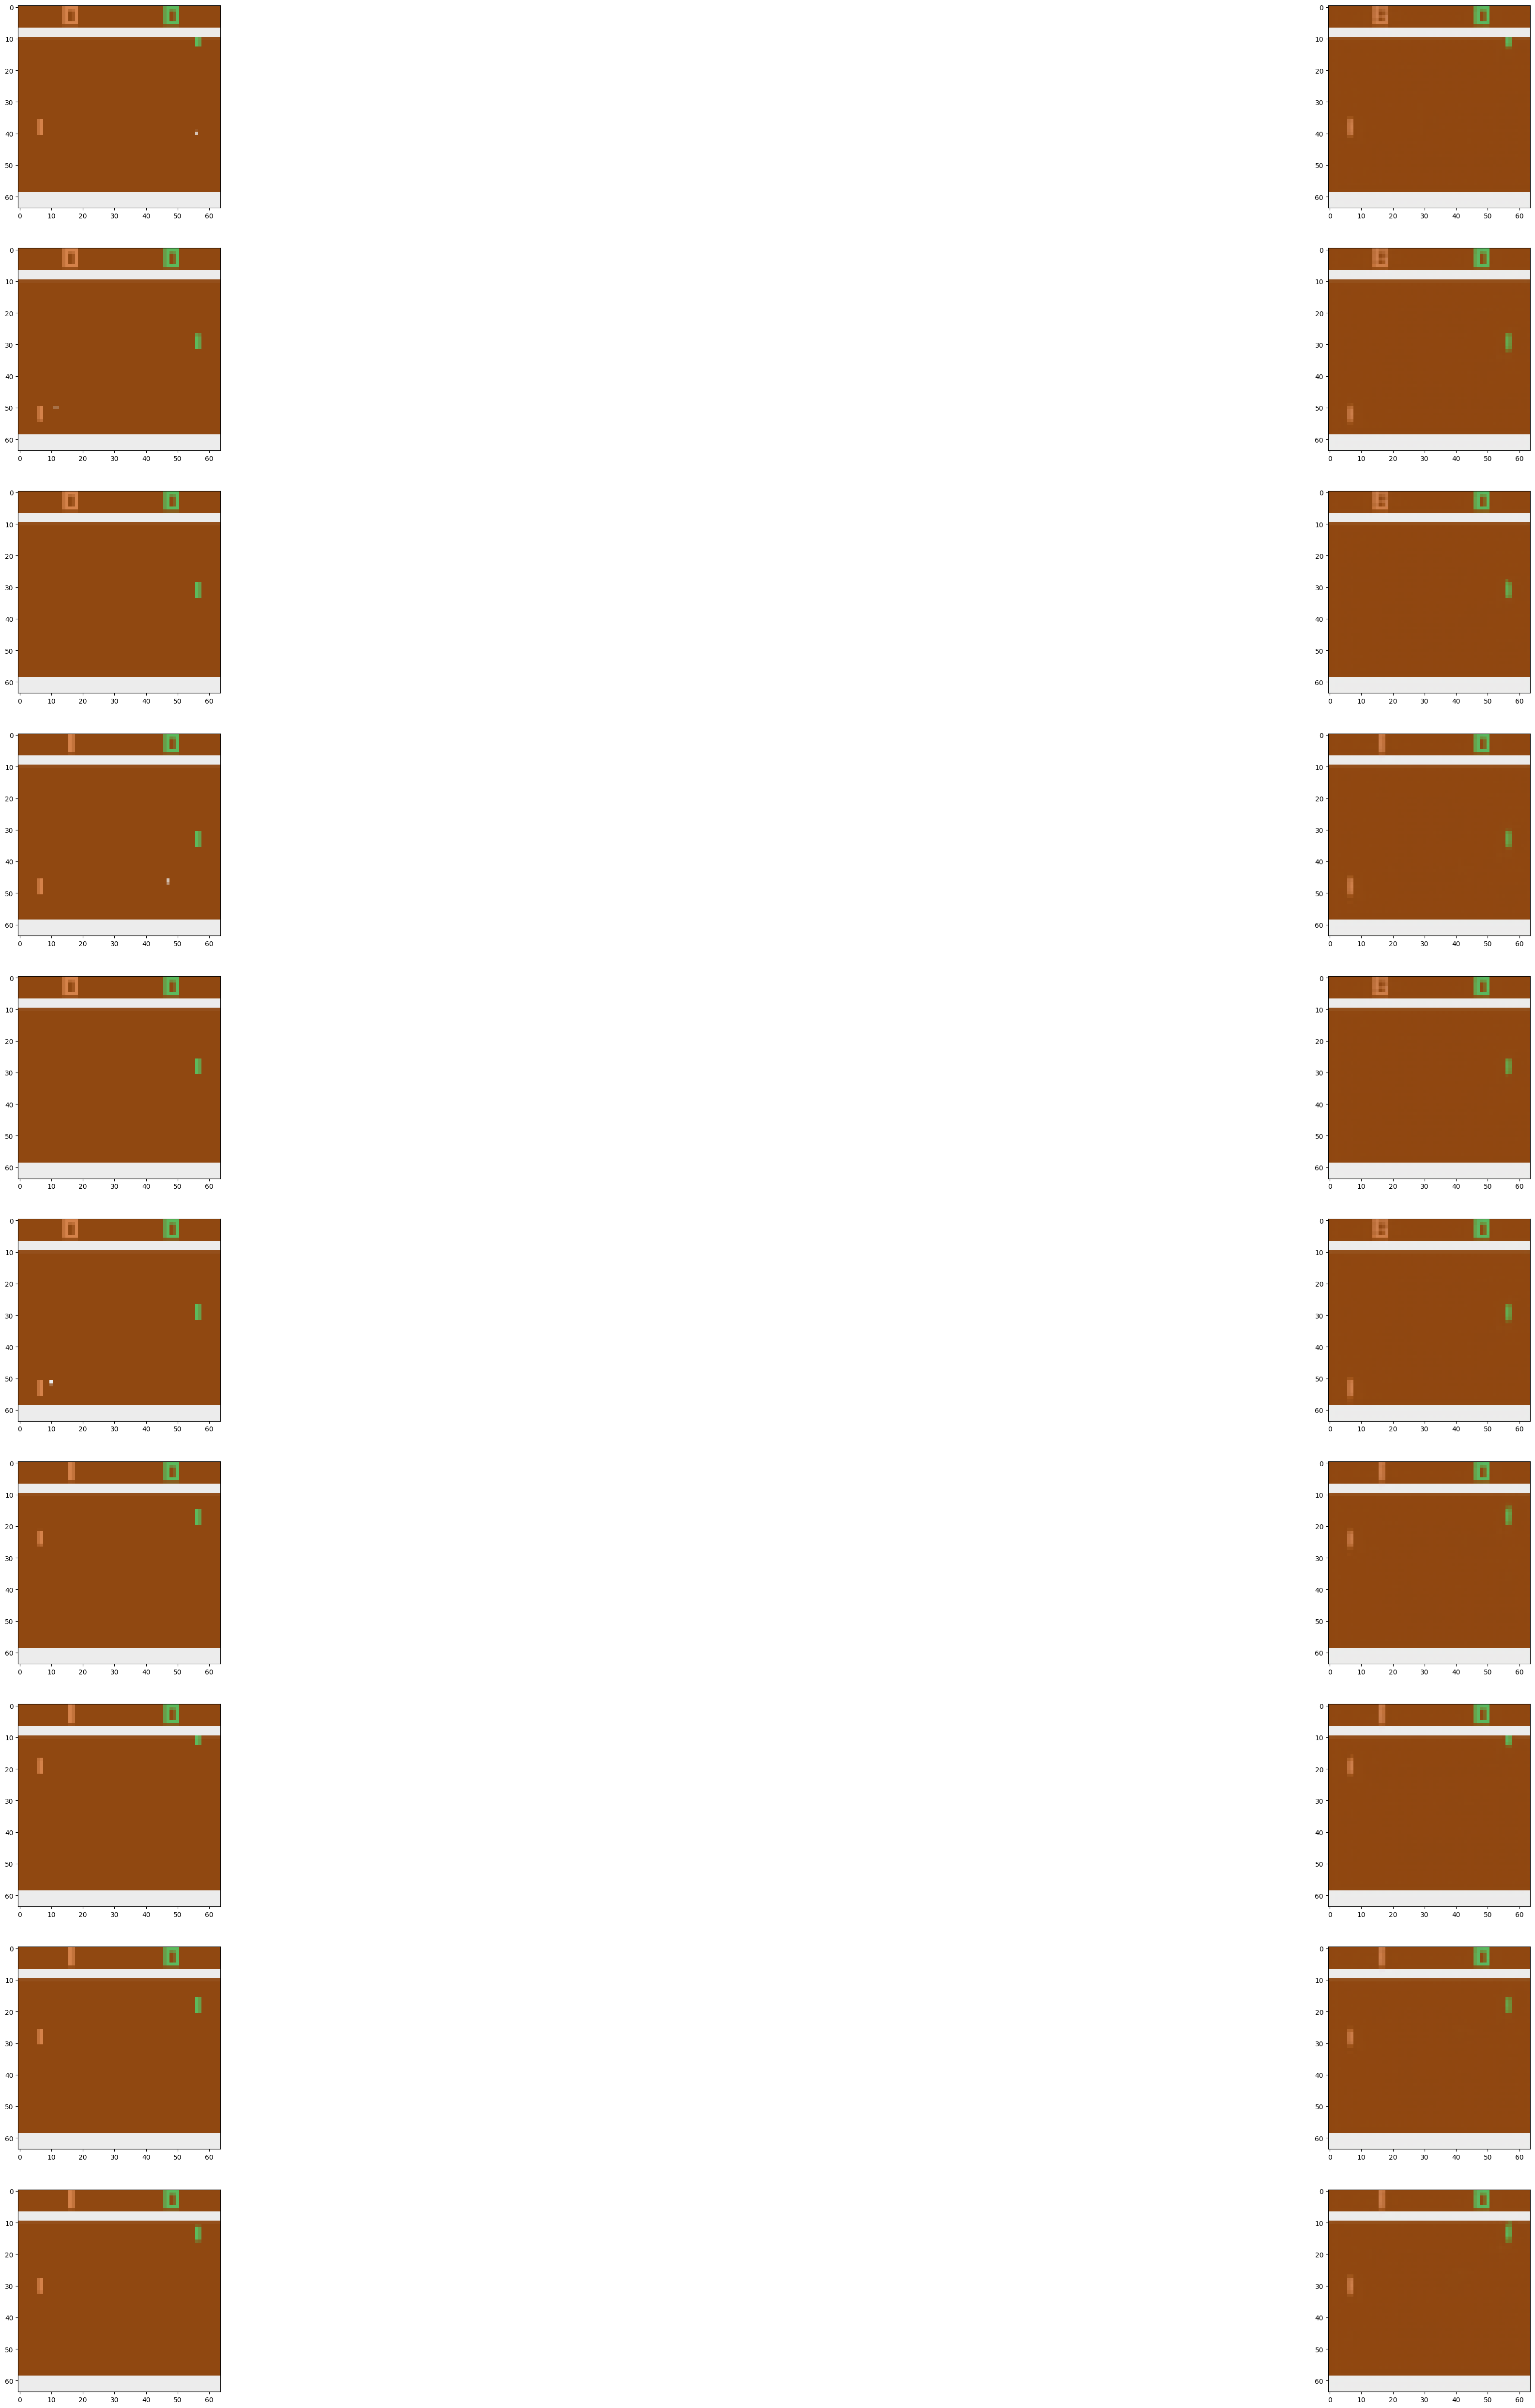

In [21]:
from matplotlib import pyplot as plt

num_rows = 10
img_dataset = eval_dataset.unbatch().shuffle(100).batch(num_rows)
img_in, _ = iter(img_dataset).next()
img_out = model(img_in)
img_in = img_in.numpy().astype(np.uint8)[:num_rows]
img_out = img_out.numpy().astype(np.uint8)[:num_rows]

fig = plt.figure(figsize=(64, 64))

for i in range(num_rows):
    fig.add_subplot(num_rows, 2, i*2+1)
    plt.imshow(img_in[i])
    fig.add_subplot(num_rows, 2, i*2+2)
    plt.imshow(img_out[i])